In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
df = pd.read_csv('Data/Insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
#Quick check of duplicates or missing values

print(df.duplicated().sum())
print(df.isna().sum().sum())

1
0


In [5]:
#Drop our one duplicate row

df = df.drop_duplicates()

df.duplicated().sum()

0

# Q1 - Do smokers have higher insurance charges than non-smokers?

### Null hypothesis: There is no statistical difference in charges between smokers and non-smokers

### Alternate hypothesis: There is a statistical difference in charges between smokers and non-smokers

### Alpha will be .05

### Since we are dealing with a single variable (charges) between two groups we can do a T-Test

In [6]:
#Let's check the balance between males and females in our dataframe

df['sex'].value_counts()

male      675
female    662
Name: sex, dtype: int64

In [7]:
#Very balanced. Let's create two new dataframes of male and female charges

male_df = df.loc[df['sex']=="male"].copy()
female_df = df.loc[df['sex']=='female'].copy()

male_charges = male_df['charges']
female_charges = female_df['charges']

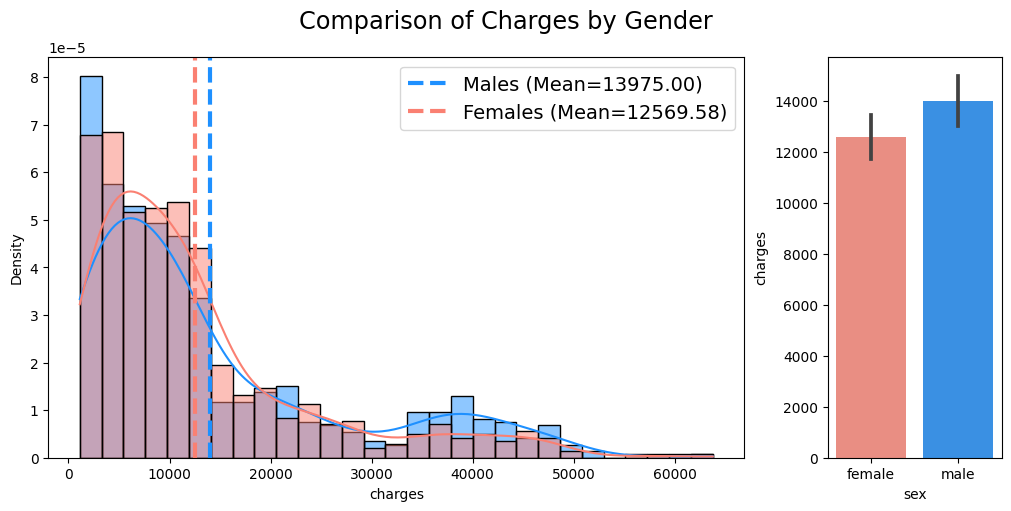

In [13]:
#Let's visualize our data before we perform our test  ##Code is modified version from Learn Platform

gender_palette={'male':'dodgerblue', 'female':'salmon'}
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='sex',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=gender_palette)

ax.axvline(np.mean(male_charges), ls='--',lw=3, 
           label=f"Males (Mean={np.mean(male_charges):.2f})",color=gender_palette['male'])

ax.axvline(np.mean(female_charges), ls='--', lw=3, 
           label=f"Females (Mean={np.mean(female_charges):.2f})",color=gender_palette['female'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='sex',y='charges',ax = ax_bar,palette=gender_palette)
fig.suptitle('Comparison of Charges by Gender',fontsize='xx-large');

### Before we can run our T-Test, we need to verify a few things about our data

### Verification 1 - No significant outliers

In [14]:
#Check males for outliers using z_score

male_zscores = stats.zscore(male_charges)
male_outliers = abs(male_zscores)>3
np.sum(male_outliers)

2

In [15]:
#we have two outliers for males, let's remove them

male_charges = male_charges[(np.abs(stats.zscore(male_charges))<3)]

In [16]:
#Check females for outliers

female_zscores = stats.zscore(female_charges)
female_outliers = abs(female_zscores)>3
np.sum(female_outliers)

14

In [17]:
#Remove female outliers

female_charges = female_charges[(np.abs(stats.zscore(female_charges))<3)]

### Verification 2 - Check for normality

In [18]:
#Check males for normality

males_normality = stats.normaltest(male_charges)
males_normality

NormaltestResult(statistic=125.6448718346262, pvalue=5.20670223236575e-28)

In [20]:
#Check females for normality

females_normality = stats.normaltest(female_charges)
females_normality

NormaltestResult(statistic=183.78486023459502, pvalue=1.234879756848696e-40)

### Both of our groups had p-values well below .05, which means both are NOT normally distributed. Our sample sizes for both groups are 600+ though, so we can continue with our T-Test

### Verification 3 - Check for equal variance

In [21]:
variance_test = stats.levene(male_charges, female_charges)
variance_test

LeveneResult(statistic=21.05823462931232, pvalue=4.879548376431153e-06)

### With a p-value of under .05, we can conclude that our two samples do NOT have equal variance. This won't stop us from conducting our test, but we will need to set our equal_var to False when running it

### Now we can run our test!

In [22]:
t_test = stats.ttest_ind(male_charges, female_charges, equal_var = False)
t_test

Ttest_indResult(statistic=3.3291497387660622, pvalue=0.0008963785563638305)

## RESULTS: With a p-value of well under .05, we can reject our null hypothesis and accept that there is clearly a statistically significant difference between male and female charges!

# Q2 - Are men more likely to smoke than women?

### Null hypothesis: There is no statistical difference in the chances of being a smoker between men and women

### Alternate hypothesis: There is a statistical difference in the chances of being a smoker between men and women

### Alpha will once again be .05

### Since we are dealing with categorical data and its relationship to a binary target, we will use Chi-Squared

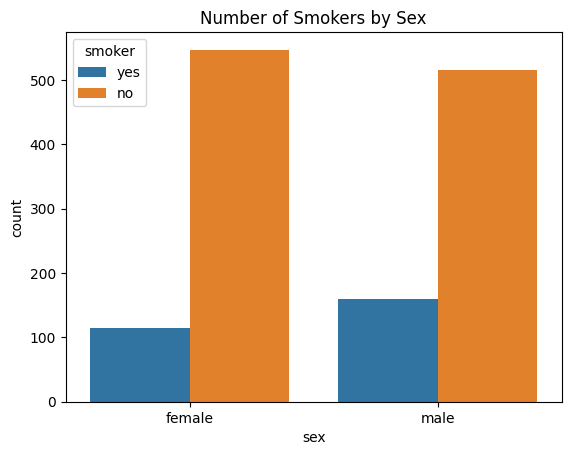

In [30]:
#Let's visualize our data to get an idea of what we're working with

ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title("Number of Smokers by Sex")
plt.show()

In [25]:
#Create our contingency table

table = pd.crosstab(df['sex'],df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [26]:
#Now we can run the test and save our results into variables

chi_squared = stats.chi2_contingency(table)

chi2, p, deg_free, expected_vals = chi_squared

print(p)
p<.05

0.0062765550120107375


True

## RESULTS: With a p-value of under .05, we can reject our null hypothesis and accept that there is indeed a statistically significant difference between the liklihood of being a smoker between males and females (with males being more likely)

# Q2 - Do different regions have different charges, on average?

### Null hypothesis: There is no statistical difference in the average charges between regions

### Alternate hypothesis: There is a statistical difference in the average charges between different regions

### Alpha will once again be .05

### Since we are dealing with numerical data across many groups, we will use ANOVA & Tukey

In [27]:
#Let's see how many regions we're truly dealing with and how balanced they are

df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

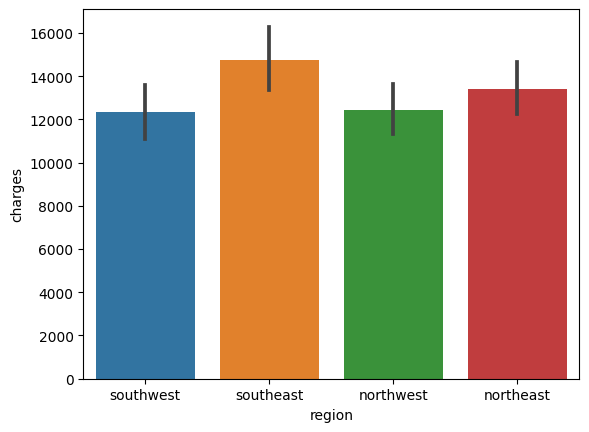

In [29]:
#Let's visualize our averages to see if anything stands out right away

sns.barplot(data=df, x='region', y='charges')
plt.show()

### Before we can run our ANOVA, we will once again need to verify a few things about our data

### Before we start that process, let's separate out our groups into a dictionary

In [31]:
groups = {}

for i in df['region'].unique():
    data = df.loc[df['region']==i, 'charges'].copy()
    groups[i] = data
    
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Now let's test for normality


In [33]:
normality = {}

for i, data in groups.items():
    stat, p = stats.normaltest(data)
    normality[i] = {'n':len(data), 'p':p, 'test stat':stat}
    
normality_df = pd.DataFrame(normality).T
normality_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,324.0,6.502634e-24,106.779670
northeast,324.0,1.455431e-19,86.747629


### With every single group having a p-value below .05, we can conclude that NONE of our groups have a normal distribution. But with high sample sizes in all groups, we can continue with our test

## Now let's test for equal variance 

In [34]:
stats.levene(*groups.values())

LeveneResult(statistic=5.553479860699911, pvalue=0.0008689544824002284)

### With a p-value below .05, we also do NOT have equal variance in our groups. This does not stop us from continuing, but we will need to shift gears to a Kruskal-Wallis function instead

In [37]:
#Let's run our final test!

anova = stats.kruskal(*groups.values())
anova

KruskalResult(statistic=4.622506584464645, pvalue=0.20161983372311595)

## RESULTS: With a p-value of over .05, we must reject our alternate hypothesis and will conclude that there is NOT a statistically significant difference between the charges within different regions